# Portfolio Optimization: Markowitz Mean-Variance Theory

## Introduction

Modern Portfolio Theory (MPT), developed by Harry Markowitz in 1952, revolutionized investment management by providing a mathematical framework for assembling a portfolio of assets that maximizes expected return for a given level of risk. This notebook implements the Markowitz mean-variance optimization model and visualizes the efficient frontier.

## Theoretical Foundation

### Portfolio Return

For a portfolio of $n$ assets with weights $\mathbf{w} = (w_1, w_2, \ldots, w_n)^T$, the expected portfolio return is:

$$\mu_p = \mathbf{w}^T \boldsymbol{\mu} = \sum_{i=1}^{n} w_i \mu_i$$

where $\boldsymbol{\mu} = (\mu_1, \mu_2, \ldots, \mu_n)^T$ is the vector of expected returns for each asset.

### Portfolio Variance

The portfolio variance (risk) is given by:

$$\sigma_p^2 = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of asset returns, with elements $\sigma_{ij} = \text{Cov}(r_i, r_j)$.

### The Optimization Problem

The Markowitz optimization problem can be formulated in several ways:

**1. Minimize variance for a target return:**

$$\min_{\mathbf{w}} \quad \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

subject to:
$$\mathbf{w}^T \boldsymbol{\mu} = \mu_{\text{target}}$$
$$\mathbf{w}^T \mathbf{1} = 1$$

**2. Maximize the Sharpe Ratio:**

$$\max_{\mathbf{w}} \quad \frac{\mu_p - r_f}{\sigma_p}$$

where $r_f$ is the risk-free rate.

### Efficient Frontier

The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk. Mathematically, it is the upper boundary of the feasible region in the risk-return space.

### Capital Market Line (CML)

When a risk-free asset is available, the optimal portfolio lies on the Capital Market Line:

$$\mu_p = r_f + \frac{\mu_M - r_f}{\sigma_M} \sigma_p$$

where $(\sigma_M, \mu_M)$ is the tangency (market) portfolio.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed for reproducibility
np.random.seed(42)

# Define number of assets
n_assets = 5
asset_names = ['Stock A', 'Stock B', 'Stock C', 'Stock D', 'Stock E']

# Generate synthetic expected returns (annualized)
expected_returns = np.array([0.12, 0.18, 0.15, 0.10, 0.14])

# Generate a realistic covariance matrix
# Start with standard deviations (annualized)
std_devs = np.array([0.15, 0.25, 0.20, 0.12, 0.18])

# Create correlation matrix with realistic correlations
correlation_matrix = np.array([
    [1.00, 0.30, 0.25, 0.40, 0.35],
    [0.30, 1.00, 0.60, 0.20, 0.50],
    [0.25, 0.60, 1.00, 0.15, 0.45],
    [0.40, 0.20, 0.15, 1.00, 0.30],
    [0.35, 0.50, 0.45, 0.30, 1.00]
])

# Convert correlation matrix to covariance matrix
cov_matrix = np.outer(std_devs, std_devs) * correlation_matrix

print("Expected Returns (annualized):")
for name, ret in zip(asset_names, expected_returns):
    print(f"  {name}: {ret:.1%}")

print("\nStandard Deviations (annualized):")
for name, std in zip(asset_names, std_devs):
    print(f"  {name}: {std:.1%}")

print("\nCovariance Matrix:")
print(np.round(cov_matrix, 4))

Expected Returns (annualized):
  Stock A: 12.0%
  Stock B: 18.0%
  Stock C: 15.0%
  Stock D: 10.0%
  Stock E: 14.0%

Standard Deviations (annualized):
  Stock A: 15.0%
  Stock B: 25.0%
  Stock C: 20.0%
  Stock D: 12.0%
  Stock E: 18.0%

Covariance Matrix:
[[0.0225 0.0112 0.0075 0.0072 0.0094]
 [0.0112 0.0625 0.03   0.006  0.0225]
 [0.0075 0.03   0.04   0.0036 0.0162]
 [0.0072 0.006  0.0036 0.0144 0.0065]
 [0.0094 0.0225 0.0162 0.0065 0.0324]]


In [2]:
def portfolio_return(weights, expected_returns):
    """Calculate portfolio expected return."""
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights, cov_matrix):
    """Calculate portfolio standard deviation (volatility)."""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """Calculate portfolio Sharpe ratio."""
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - risk_free_rate) / vol

def minimize_volatility(target_return, expected_returns, cov_matrix):
    """Find minimum volatility portfolio for a given target return."""
    n = len(expected_returns)
    
    # Objective: minimize portfolio variance
    def objective(weights):
        return portfolio_volatility(weights, cov_matrix)
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, expected_returns) - target_return}  # target return
    ]
    
    # Bounds: no short selling (weights between 0 and 1)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/n] * n)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

def find_efficient_frontier(expected_returns, cov_matrix, n_points=100):
    """Calculate the efficient frontier."""
    # Find the range of feasible returns
    min_ret = np.min(expected_returns)
    max_ret = np.max(expected_returns)
    
    # Generate target returns
    target_returns = np.linspace(min_ret, max_ret, n_points)
    
    efficient_portfolios = []
    
    for target in target_returns:
        result = minimize_volatility(target, expected_returns, cov_matrix)
        if result.success:
            vol = portfolio_volatility(result.x, cov_matrix)
            efficient_portfolios.append((vol, target, result.x))
    
    return efficient_portfolios

In [3]:
def find_minimum_variance_portfolio(expected_returns, cov_matrix):
    """Find the global minimum variance portfolio."""
    n = len(expected_returns)
    
    def objective(weights):
        return portfolio_volatility(weights, cov_matrix)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array([1/n] * n)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x, portfolio_return(result.x, expected_returns), portfolio_volatility(result.x, cov_matrix)

def find_max_sharpe_portfolio(expected_returns, cov_matrix, risk_free_rate):
    """Find the maximum Sharpe ratio portfolio (tangency portfolio)."""
    n = len(expected_returns)
    
    def neg_sharpe(weights):
        return -portfolio_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.array([1/n] * n)
    
    result = minimize(neg_sharpe, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x, portfolio_return(result.x, expected_returns), portfolio_volatility(result.x, cov_matrix)

# Risk-free rate
risk_free_rate = 0.03

# Find special portfolios
mvp_weights, mvp_return, mvp_vol = find_minimum_variance_portfolio(expected_returns, cov_matrix)
msp_weights, msp_return, msp_vol = find_max_sharpe_portfolio(expected_returns, cov_matrix, risk_free_rate)

print("Minimum Variance Portfolio:")
print(f"  Expected Return: {mvp_return:.2%}")
print(f"  Volatility: {mvp_vol:.2%}")
print(f"  Sharpe Ratio: {(mvp_return - risk_free_rate)/mvp_vol:.3f}")
print("  Weights:")
for name, w in zip(asset_names, mvp_weights):
    if w > 0.001:
        print(f"    {name}: {w:.1%}")

print("\nMaximum Sharpe Ratio Portfolio (Tangency Portfolio):")
print(f"  Expected Return: {msp_return:.2%}")
print(f"  Volatility: {msp_vol:.2%}")
print(f"  Sharpe Ratio: {(msp_return - risk_free_rate)/msp_vol:.3f}")
print("  Weights:")
for name, w in zip(asset_names, msp_weights):
    if w > 0.001:
        print(f"    {name}: {w:.1%}")

Minimum Variance Portfolio:
  Expected Return: 11.47%
  Volatility: 10.33%
  Sharpe Ratio: 0.820
  Weights:
    Stock A: 21.2%
    Stock C: 14.3%
    Stock D: 56.1%
    Stock E: 8.4%

Maximum Sharpe Ratio Portfolio (Tangency Portfolio):
  Expected Return: 12.66%
  Volatility: 11.09%
  Sharpe Ratio: 0.871
  Weights:
    Stock A: 23.0%
    Stock B: 9.3%
    Stock C: 18.1%
    Stock D: 35.8%
    Stock E: 13.9%


In [4]:
# Calculate efficient frontier
efficient_portfolios = find_efficient_frontier(expected_returns, cov_matrix, n_points=100)

# Extract volatilities and returns
ef_vols = [p[0] for p in efficient_portfolios]
ef_rets = [p[1] for p in efficient_portfolios]

# Generate random portfolios for comparison
n_random = 5000
random_vols = []
random_rets = []
random_sharpes = []

for _ in range(n_random):
    # Generate random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol
    
    random_vols.append(vol)
    random_rets.append(ret)
    random_sharpes.append(sharpe)

print(f"Generated {n_random} random portfolios")
print(f"Efficient frontier contains {len(efficient_portfolios)} optimal portfolios")

Generated 5000 random portfolios
Efficient frontier contains 100 optimal portfolios


Plot saved to 'plot.png'


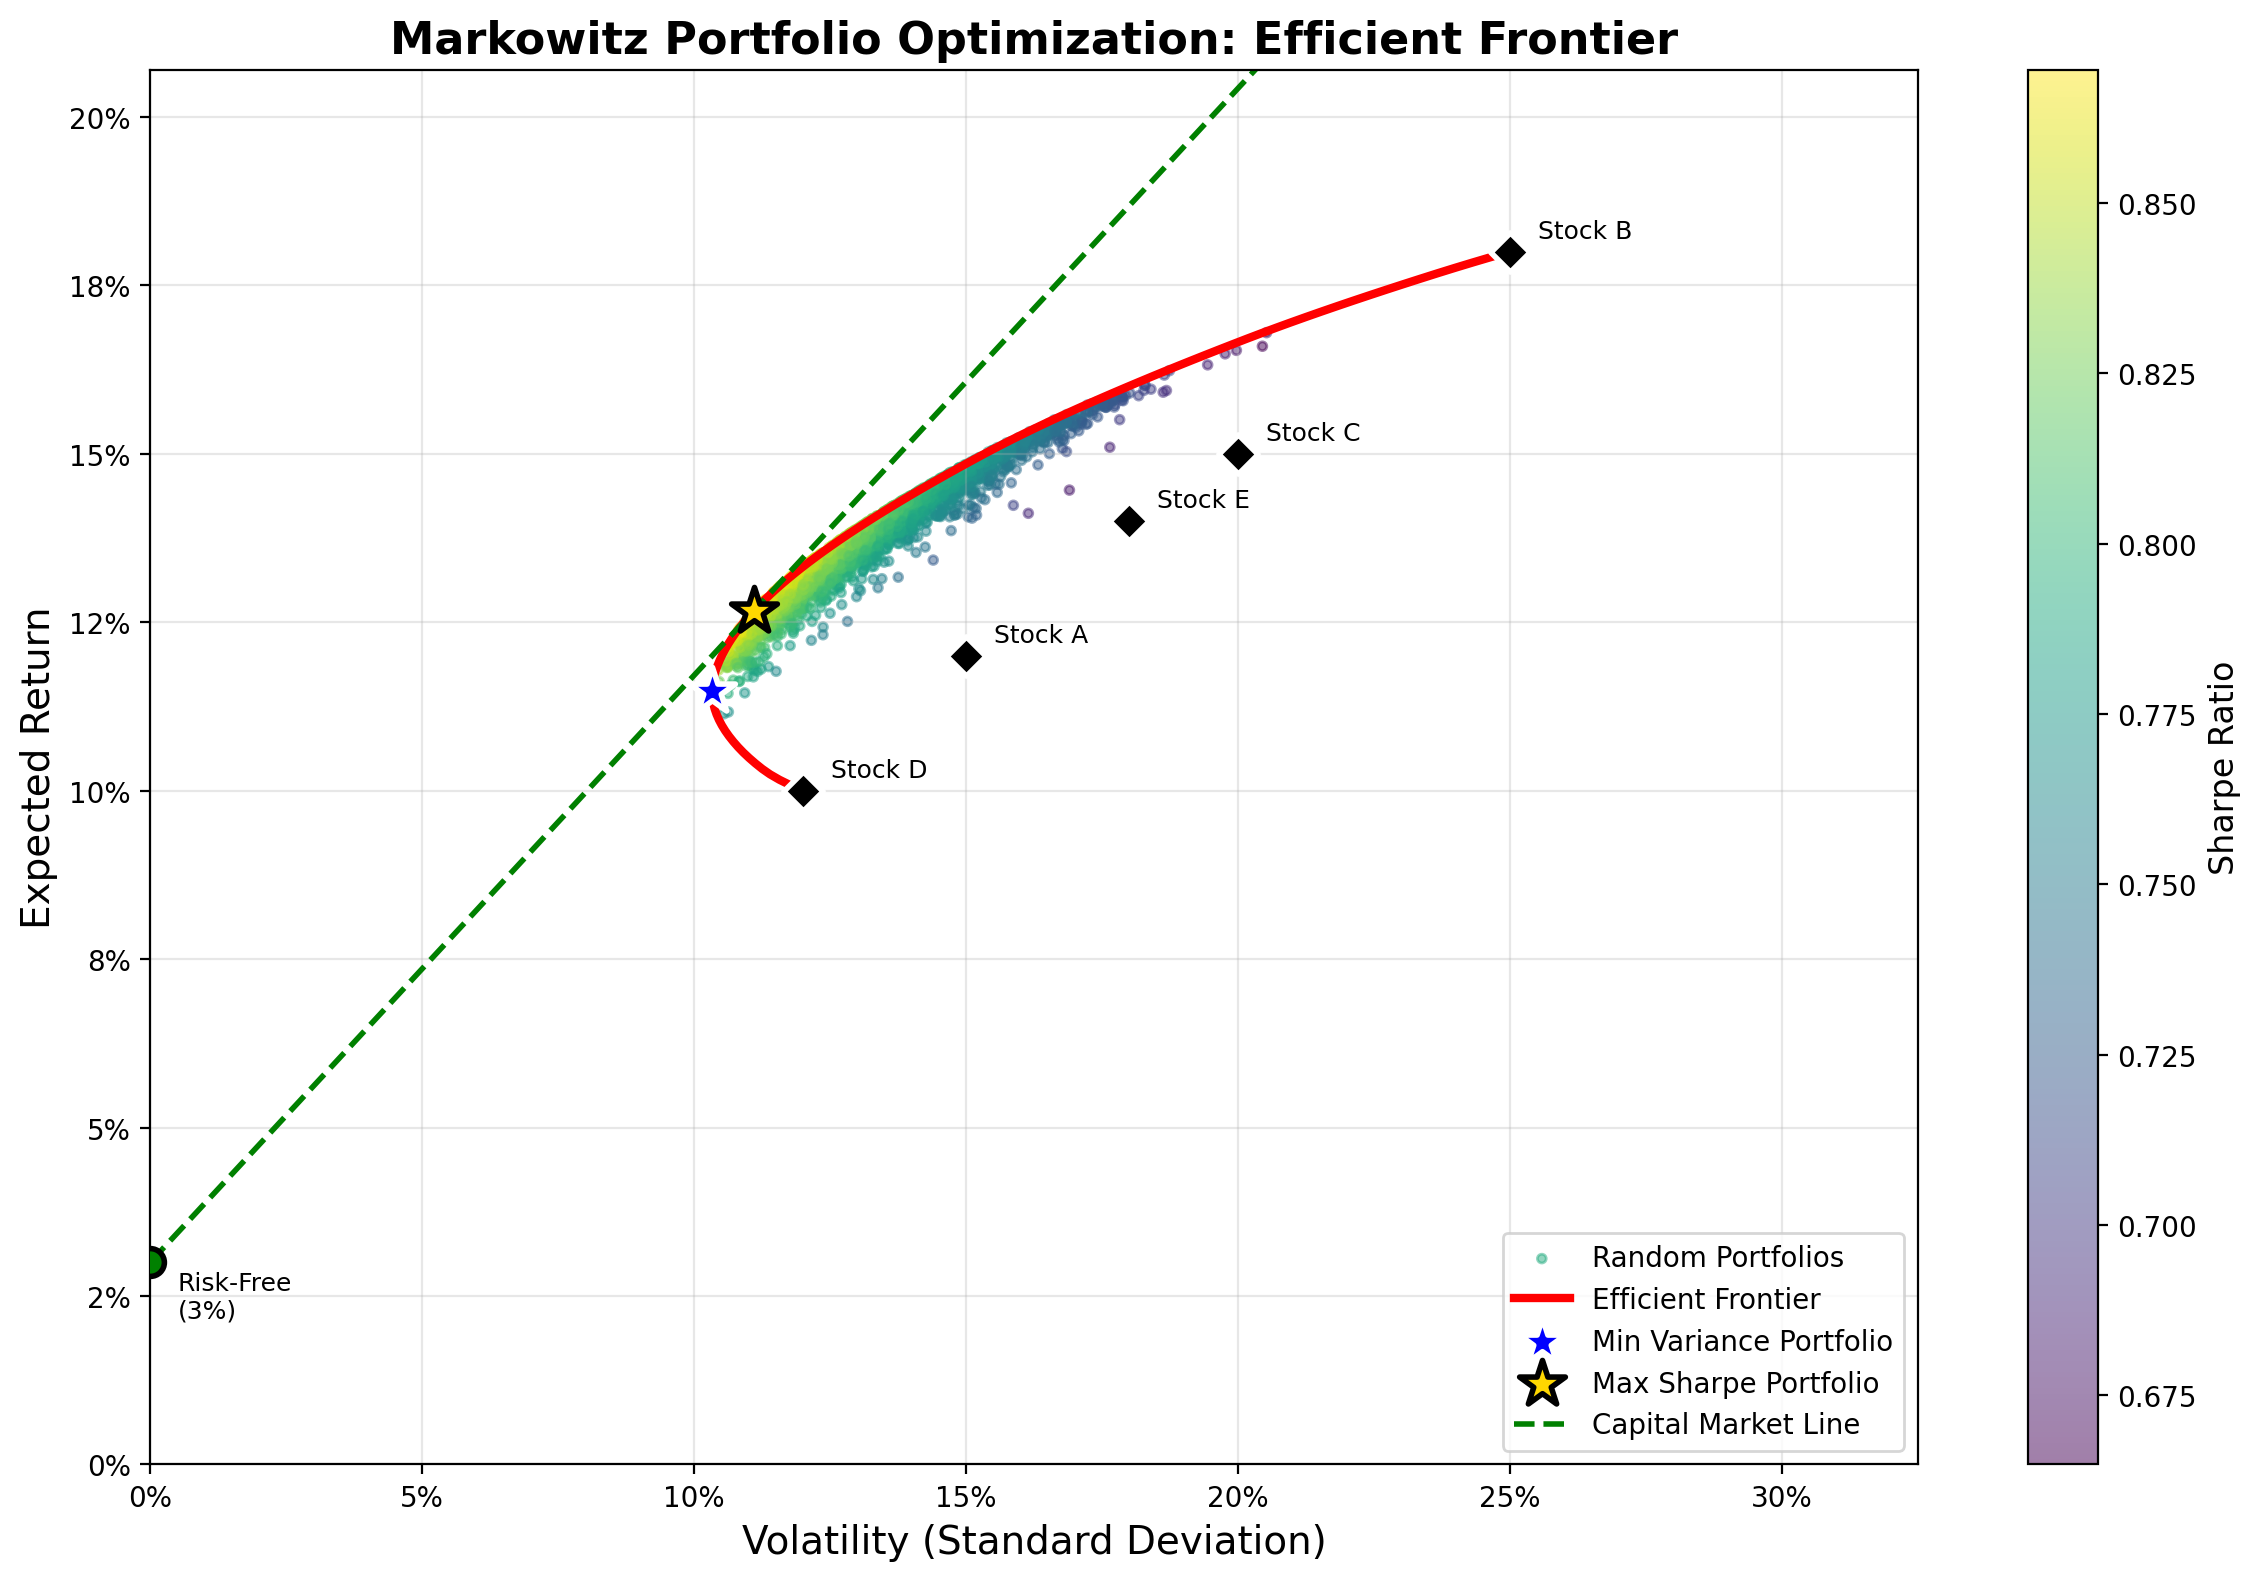

In [5]:
# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot random portfolios colored by Sharpe ratio
scatter = ax.scatter(random_vols, random_rets, c=random_sharpes, 
                     cmap='viridis', alpha=0.5, s=10, label='Random Portfolios')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sharpe Ratio', fontsize=12)

# Plot efficient frontier
ax.plot(ef_vols, ef_rets, 'r-', linewidth=3, label='Efficient Frontier')

# Plot individual assets
ax.scatter(std_devs, expected_returns, marker='D', s=100, c='black', 
           edgecolors='white', linewidth=2, zorder=5)
for i, name in enumerate(asset_names):
    ax.annotate(name, (std_devs[i], expected_returns[i]), 
                xytext=(10, 5), textcoords='offset points', fontsize=9)

# Plot minimum variance portfolio
ax.scatter(mvp_vol, mvp_return, marker='*', s=300, c='blue', 
           edgecolors='white', linewidth=2, zorder=6, label='Min Variance Portfolio')

# Plot maximum Sharpe ratio portfolio
ax.scatter(msp_vol, msp_return, marker='*', s=300, c='gold', 
           edgecolors='black', linewidth=2, zorder=6, label='Max Sharpe Portfolio')

# Plot Capital Market Line
cml_x = np.linspace(0, max(ef_vols) * 1.2, 100)
cml_y = risk_free_rate + (msp_return - risk_free_rate) / msp_vol * cml_x
ax.plot(cml_x, cml_y, 'g--', linewidth=2, label='Capital Market Line')

# Plot risk-free rate
ax.scatter(0, risk_free_rate, marker='o', s=100, c='green', 
           edgecolors='black', linewidth=2, zorder=6)
ax.annotate(f'Risk-Free\n({risk_free_rate:.0%})', (0, risk_free_rate), 
            xytext=(10, -20), textcoords='offset points', fontsize=9)

# Formatting
ax.set_xlabel('Volatility (Standard Deviation)', fontsize=14)
ax.set_ylabel('Expected Return', fontsize=14)
ax.set_title('Markowitz Portfolio Optimization: Efficient Frontier', fontsize=16, fontweight='bold')

# Format axes as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

ax.set_xlim(0, max(std_devs) * 1.3)
ax.set_ylim(0, max(expected_returns) * 1.15)

ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plt.savefig('portfolio_optimization_markowitz_analysis.png', dpi=150, bbox_inches='tight')
print("Plot saved to 'plot.png'")

plt.show()

## Results Interpretation

### Key Observations

1. **Efficient Frontier**: The red curve represents the set of optimal portfolios. Any portfolio below this curve is suboptimal because we can find another portfolio with either higher return for the same risk or lower risk for the same return.

2. **Minimum Variance Portfolio**: The blue star marks the portfolio with the lowest possible risk. This portfolio lies at the leftmost point of the efficient frontier.

3. **Maximum Sharpe Ratio Portfolio**: The gold star indicates the tangency portfolio—the point where the Capital Market Line (CML) touches the efficient frontier. This portfolio offers the best risk-adjusted return.

4. **Diversification Benefit**: Notice how the efficient frontier lies to the left of most individual assets. This demonstrates the power of diversification—by combining assets, we can achieve lower risk than holding any single asset alone.

5. **Capital Market Line**: The green dashed line represents optimal portfolios when we can combine the risk-free asset with the tangency portfolio. Any point on this line dominates points on the efficient frontier (except the tangency point).

### Mathematical Insights

The optimization reveals several important properties:

- **Convexity**: The efficient frontier is convex, meaning any convex combination of efficient portfolios is also efficient or dominated by an efficient portfolio.

- **Two-Fund Separation**: Any efficient portfolio can be constructed as a combination of two efficient portfolios (e.g., the minimum variance portfolio and the maximum return portfolio).

- **Risk-Return Trade-off**: Moving along the efficient frontier from left to right increases both risk and return, illustrating the fundamental trade-off in portfolio theory.

## Conclusion

This notebook demonstrated the implementation of Markowitz Mean-Variance Portfolio Optimization, including:

1. Theoretical framework with precise mathematical formulations
2. Numerical optimization to find optimal portfolio weights
3. Computation of the efficient frontier
4. Identification of key portfolios (minimum variance and maximum Sharpe ratio)
5. Visualization of the risk-return trade-off

The Markowitz model remains a cornerstone of modern finance, providing a rigorous framework for understanding diversification and optimal asset allocation. While real-world applications require considerations beyond this basic model (transaction costs, constraints, estimation error), the fundamental insights about risk-return trade-offs and diversification benefits continue to guide investment practice.